# aSPEM Experiment : analysis

In [1]:
%run ../0_parameters.ipynb


WELCOME

2020-03-06T10:15:23+01:00

CPython 3.5.2
IPython 5.3.0

numpy 1.16.3
matplotlib 3.0.3
torch 1.1.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-83-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
host name  : INV-OPE-HP01
Git hash   : cef230850aac5d9cb4d22cd6deafc0ad7237d08f
Git repo   : https://github.com/chloepasturel/AnticipatorySPEM.git
Git branch : master


In [2]:
import pickle
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('../data/*pkl'):
    a = fname.split('/')[2].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

In [5]:
def mask_nan(h_va, h_bet, r_va, r_bet) :
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_bet)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_bet)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_va)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_va)).compressed()
    
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_va)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_va)).compressed()
    
    return h_va, h_bet, r_va, r_bet

In [6]:
def maxx_pourcentage(r_, pourcentage) :
    maxx=None
    for round_ in list(reversed(np.arange(5))) :
        if maxx is None :
            for x in range(len(r_)) :
                if np.round(r_[x], round_)==np.round(pourcentage*np.max(r_), round_) :
                    maxx=x
    return maxx

In [7]:
def print_stat(h, age) :
    from scipy import stats
    
    print('\n\t\t\tmannwhitneyu', '\tkruskal', '\t\tks_2samp', sep='')
    print('\t\t\t','-'*12, '\t', '-'*7, '\t\t', '-'*8, sep='')
    
    def stata(h1, h2) :
        man = stats.mannwhitneyu(h1, h2).pvalue
        kr = stats.kruskal(h1, h2).pvalue
        ks = stats.ks_2samp(h1, h2).pvalue
        print('%.4f'%man, '%.4f'%kr, '%.4f'%ks, sep='\t\t')
              #'\nwasserstein_distance (Earth movers distance) : ',
              #stats.wasserstein_distance(h['F'], h['M'], u_weights=r['F'], v_weights=r['M']), sep='')
        return man, kr, ks
    
    
    list_signi = []
    
    print('H vs F', end=' :\t\t')
    man, kr, ks = stata(h['F'], h['M'])
    for s in [man, kr, ks] :
        if s < 0.05 : list_signi.append('H-F') ; break
    
    for b1 in range(2) :
        for b2 in range(1, 3) :
            if b1!=b2 :
                print('BLOCK %s vs %s'%(b1,b2), end=' :\t\t')
                man, kr, ks = stata(h['b'][b1], h['b'][b2])
                for s in [man, kr, ks] :
                    if s < 0.05 : list_signi.append('B %s-%s'%(b1,b2)) ; break
                

    for a1 in age[:2] :
        for a2 in age[1:] :
            if a1!=a2 :
                print('AGE %s vs %s'%(a1,a2), end=' :\t')
                man, kr, ks = stata(h[a1], h[a2])
                for s in [man, kr, ks] :
                    if s < 0.05 : list_signi.append('A %s - %s'%(a1,a2)) ; break
                
    print('TIME a.m vs p.m', end=' :\t')
    man, kr, ks = stata(h['a.m'], h['p.m'])
    for s in [man, kr, ks] :
        if s < 0.05 : list_signi.append('a.m-p.m') ; break
    
    print('DELAI <=2 vs >2', end=' :\t')
    man, kr, ks = stata(h['<=2'], h['>2'])
    for s in [man, kr, ks] :
        if s < 0.05 : list_signi.append('D <=2 - >2') ; break
    
    for a1 in ['1', '2', '3'] :
        for a2 in ['2', '3', '4'] :
            if a1!=a2 :
                print('GROUPE %s vs %s'%(a1,a2), end=' :\t\t')
                man, kr, ks = stata(h[a1], h[a2])
                for s in [man, kr, ks] :
                    if s < 0.05 : list_signi.append('G %s-%s'%(a1,a2)) ; break
    
    
    print('\nSignificatif :', list_signi)
    return list_signi

In [8]:
suj = ['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09', 's10',  's11', 's12']

list_suj = {'s01': 'F', 's02': 'M', 's03': 'F', 's04': 'F',
            's05': 'F', 's06': 'F', 's07': 'F', 's08': 'M',
            's09': 'M', 's10': 'F', 's11': 'M', 's12': 'M'}

age_suj = {'s01': 44, 's02': 24, 's03': 28, 's04': 27,
           's05': 30, 's06': 26, 's07': 27, 's08': 31,
           's09': 28, 's10': 25, 's11': 28, 's12': 30}

# 2 sujet -25  # 6 sujet 26-29 # 4 sujets 30-
# 3 sujet -26  # 5 sujet 27-29 # 4 sujets 30-
age=['-26', '27-29', '30-']
for s in age_suj.keys() :
    if age_suj[s]<=26 :   age_suj[s]='-26'
    elif age_suj[s]<=29 : age_suj[s]='27-29'
    else :                age_suj[s]='30-'
        
time_va = {'s01': 'a.m', 's02': 'a.m', 's03': 'p.m', 's04': 'p.m',
           's05': 'p.m', 's06': 'a.m', 's07': 'p.m', 's08': 'a.m',
           's09': 'a.m', 's10': 'p.m', 's11': 'p.m', 's12': 'p.m'}

time_bet = {'s01': 'a.m', 's02': 'p.m', 's03': 'p.m', 's04': 'p.m',
            's05': 'p.m', 's06': 'a.m', 's07': 'p.m', 's08': 'a.m',
            's09': 'a.m', 's10': 'a.m', 's11': 'p.m', 's12': 'p.m'}
        
date_va = {'s01': '17-10-23', 's02': '17-09-26', 's03': '17-10-03', 's04': '17-09-27',
           's05': '17-10-03', 's06': '17-09-28', 's07': '17-09-20', 's08': '17-10-26',
           's09': '17-11-08', 's10': '17-11-16', 's11': '17-11-08', 's12': '17-11-17'}

date_bet = {'s01': '17-09-29', 's02': '17-06-25', 's03': '17-09-28', 's04': '17-09-26',
            's05': '17-09-26', 's06': '19-09-26', 's07': '17-09-19', 's08': '17-10-24',
            's09': '17-11-07', 's10': '17-11-14', 's11': '17-11-08', 's12': '17-11-06'}

delai = {'s01': 24, 's02': 1, 's03': 5, 's04': 1,
         's05':  7, 's06': 2, 's07': 1, 's08': 2,
         's09':  1, 's10': 2, 's11': 0, 's12': 11}

delai = {'s01': '>2', 's02': '<=2', 's03': '>2', 's04': '<=2',
         's05': '>2', 's06': '<=2', 's07': '<=2','s08': '<=2' ,
         's09': '<=2','s10': '<=2', 's11': '<=2','s12': '>2'}
'''
groupe = {'s01': '1', 's02': '1', 's03': '2', 's04': '2',
          's05': '2', 's06': '1', 's07': '3', 's08': '4' ,
          's09': '4', 's10': '3', 's11': '4', 's12': '3'}
'''
# 1 : études scientifique
# 2 : études psycho
# 3 : études art
# 4 : autre

groupe = {'s01': '1', 's02': '1', 's03': '2', 's04': '4',
          's05': '3', 's06': '2', 's07': '4', 's08': '1',
          's09': '4', 's10': '2', 's11': '3', 's12': '4'}


In [9]:
def plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=0.99, triangle=True, age=age) :
    
    if triangle is True : from matplotlib.patches import Polygon
    
    Full = e.Full_list(modes_bcp=[])
    list_h = recording['list_h'][:max_tau]
    COLOR = ['b', 'r', 'k', 'g', 'm', 'c', 'gold', 'darkred', 'peru', 'silver', 'plum', 'olivedrab']
    c_block = ['olive', 'peru', 'brown']
    c_s = ['crimson', 'teal']
    
    
    fig = plt.figure(figsize=(15,15))
    import matplotlib.gridspec as gridspec
    #gs = gridspec.GridSpec(5, 5)
    #'''ax_ = plt.subplot(gs[1:5, :4])
    #ax_x, ax_y = plt.subplot(gs[0, :4]), plt.subplot(gs[1:5, 4])'''

    gs = gridspec.GridSpec(11, 11)
    ax_ = plt.subplot(gs[6:, :5])
    ax_x,  ax_y  = plt.subplot(gs[5, :5]), plt.subplot(gs[6:, 5])
    ax_x1, ax_y1 = plt.subplot(gs[4, :5]), plt.subplot(gs[6:, 6])
    ax_x2, ax_y2 = plt.subplot(gs[3, :5]), plt.subplot(gs[6:, 7])
    ax_x3, ax_y3 = plt.subplot(gs[2, :5]), plt.subplot(gs[6:, 8])
    ax_x4, ax_y4 = plt.subplot(gs[1, :5]), plt.subplot(gs[6:, 9])
    ax_x5, ax_y5 = plt.subplot(gs[0, :5]), plt.subplot(gs[6:, 10])

    
    # DECO
    #---------------------------------------------------------------
    ax_.plot(np.arange(-10,10), np.arange(-10,10), '-k', alpha=0.5, lw=1)
    opt=dict(colors='k', linestyles='-', alpha=0.4)
    ax_.vlines(0.025, 0, 0.025, **opt) ; ax_.hlines(0.025, 0, 0.025, **opt)
    ax_.set_xlabel('$h_{va}$', fontsize=20) ; ax_.set_ylabel('$h_{bet}$', fontsize=20)
    
    lim = (min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax_.set_xlim(lim)     ; ax_.set_ylim(lim)
    ax_.set_xscale("log") ; ax_.set_yscale("log")
    
    ax_xC, ax_yC = ax_x.twinx(), ax_y.twiny()
    ax_x1C, ax_y1C = ax_x1.twinx(), ax_y1.twiny()
    ax_x2C, ax_y2C = ax_x2.twinx(), ax_y2.twiny()
    ax_x3C, ax_y3C = ax_x3.twinx(), ax_y3.twiny()
    ax_x4C, ax_y4C = ax_x4.twinx(), ax_y4.twiny()
    ax_x5C, ax_y5C = ax_x5.twinx(), ax_y5.twiny()
    
    
    
    for a,l in zip([ax_xC,ax_x1C,ax_x2C,ax_x3C,ax_x4C,ax_x5C], ['H vs F','Block','age','time','delai','groupe']) : a.set_ylabel(l,color='k') ; a.tick_params('y',colors='r')
    for a,l in zip([ax_yC,ax_y1C,ax_y2C,ax_y3C,ax_y4C,ax_y5C], ['H vs F','Block','age','time','delai','groupe']) : a.set_xlabel(l,color='k') ; a.tick_params('x',colors='r')
    
    lim = (np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10))
    for a in [ax_x, ax_xC, ax_x1, ax_x1C, ax_x2, ax_x2C, ax_x3, ax_x3C, ax_x4, ax_x4C, ax_x5, ax_x5C] :
        a.set_xlim(lim) ; a.set_xticks(())
    for a in [ax_y, ax_yC, ax_y1, ax_y1C, ax_y2, ax_y2C, ax_y3, ax_y3C, ax_y4, ax_y4C, ax_y5, ax_y5C] :
        a.set_ylim(lim) ; a.set_yticks(())

    #axis_r = [min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100,
    #          min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100]
    
    #---------------------------------------------------------------
    h_va, h_bet, r_va, r_bet = {}, {}, {}, {}
    for l in [h_va, h_bet, r_va, r_bet] :
        l['full'], l['b'] = [], [[],[],[]]
        for s in ['F', 'M'] : l[s]=[]
        for a in age :        l[a]=[]
        for t in ['a.m', 'p.m'] : l[t]=[]
        for d in ['<=2', '>2'] : l[d]=[]
        for lu in ['1', '2', '3', '4'] : l[lu]=[]
        
    #---------------------------------------------------------------
    for num, s in enumerate(suj) :
        if list_suj[s]=='F' : coco=c_s[0]
        else :                coco=c_s[1]
        
        print(s, end=' ')

        h_va_s, h_bet_s, r_va_s, r_bet_s = [], [], [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :
            r_va_d, r_bet_d = recording['r_va'][s][d][:max_tau], recording['r_bet'][s][d][:max_tau]

            if pourcentage is not None :
                #pourcentage
                #-----------------------------------------------------------------------
                if np.argmax(r_va_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_va_d, pourcentage)
                    r_va_s.append(r_va_d[maxx]) ; h_va_s.append(list_h[maxx])
                else : r_va_s.append(np.max(r_va_d)) ; h_va_s.append(list_h[np.argmax(r_va_d)])

                if np.argmax(r_bet_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_bet_d, pourcentage)
                    r_bet_s.append(r_bet_d[maxx])   ; h_bet_s.append(list_h[maxx])
                else : r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
                #-----------------------------------------------------------------------
            else :
                r_va_s.append(np.max(r_va_d))   ; h_va_s.append(list_h[np.argmax(r_va_d)])
                r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
                
            h_va['b'][d].append(h_va_s[d]) ; h_bet['b'][d].append(h_bet_s[d])
            r_va['b'][d].append(r_va_s[d]) ; r_bet['b'][d].append(r_bet_s[d])
        
        #-----------------------------------------------------------------------
        if triangle is True :
            tritri = np.array([[h_va_s[y], h_bet_s[y]] for y in range(len(h_va_s))])
            popo = Polygon(tritri, edgecolor=coco, alpha=0.4, lw=1.2, facecolor='none') # color=COLOR[num]
            ax_.add_artist(popo)
        
        #-----------------------------------------------------------------------           
        opt = dict(alpha=0.5, lw=0, edgecolors=coco) # c=COLOR[num], lw=3
        if s in ['TN', 'LB'] :
            ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*600,
                        marker='*', c=c_block[:1], zorder=100, lw=0.5, edgecolors='k')
        else :
            ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*600,
                        c=c_block[:1], zorder=50, **opt)

        ax_.scatter(h_va_s[1:], h_bet_s[1:], s=(np.array(r_va_s[1:])*np.array(r_bet_s[1:]))*600,
                    c=c_block[1:], zorder=50, **opt)
        
        #-----------------------------------------------------------------------
        h_va['full'].extend(h_va_s) ; h_bet['full'].extend(h_bet_s)
        r_va['full'].extend(r_va_s) ; r_bet['full'].extend(r_bet_s)
        
        h_va[time_va[s]].extend(h_va_s[b] if np.isnan(h_bet_s[b])==False else np.nan for b in range(len(h_va_s)))
        h_bet[time_bet[s]].extend(h_bet_s[b] if np.isnan(h_va_s[b])==False else np.nan for b in range(len(h_va_s)))
        r_va[time_va[s]].extend(r_va_s)
        r_bet[time_bet[s]].extend(r_bet_s)
    
        
        
        
        for arg in [list_suj[s], age_suj[s], delai[s], groupe[s]] :
            h_va[arg].extend(h_va_s[b] if np.isnan(h_bet_s[b])==False else np.nan for b in range(len(h_va_s)))
            h_bet[arg].extend(h_bet_s[b] if np.isnan(h_va_s[b])==False else np.nan for b in range(len(h_va_s)))
            r_va[arg].extend(r_va_s)
            r_bet[arg].extend(r_bet_s)
    
    h_va['full'], h_bet['full'], r_va['full'], r_bet['full'] = mask_nan(h_va['full'], h_bet['full'], r_va['full'], r_bet['full'])
    r_va['full'], r_bet['full'] = np.array(r_va['full']), np.array(r_bet['full'])

    #--------------------------------------------------------------------------------------------
    # HISTOGRAMME
    #--------------------------------------------------------------------------------------------
    c_age = ['m', 'c', 'dimgrey']
    
    opt = dict(range=(np.log(min(list_h)), np.log(max(list_h))), bins=20, alpha=0.3)
    opt_c = dict(range=(np.log(min(list_h)-min(list_h)/9), np.log(max(list_h)+max(list_h)/9)),
                 bins=len(list_h), cumulative=True, histtype='step', align='mid', lw=1.5, density=True)
    
    # hist VA
    #--------------------------------------------------------------------
    for a_x, a_xC in zip([ax_x, ax_x1], [ax_xC, ax_x1C]) :
        a_x.hist(np.log(h_va['full']), weights=r_va['full'], color='dimgrey', **opt)
        a_xC.hist(np.log(h_va['full']), weights=r_va['full'], color='k', **opt_c)
    
    for a, o in zip([ax_x, ax_xC], [opt, opt_c]) :
        a.hist([np.log(h_va['F']), np.log(h_va['M'])], weights=[r_va['F'], r_va['M']], color=c_s,
               label=['F', 'M'], **o)
    
    for a, o in zip([ax_x3, ax_x3C], [opt, opt_c]) :
        a.hist([np.log(h_va['a.m']), np.log(h_va['p.m'])], weights=[r_va['a.m'], r_va['p.m']], color=['r', 'g'],
               label=['a.m', 'p.m'], **o)
    for a, o in zip([ax_x4, ax_x4C], [opt, opt_c]) :
        a.hist([np.log(h_va['<=2']), np.log(h_va['>2'])], weights=[r_va['<=2'], r_va['>2']], color=['r', 'g'],
               label=['<=2', '>2'], **o)
    for a, o in zip([ax_x5, ax_x5C], [opt, opt_c]) :
        a.hist([np.log(h_va['1']), np.log(h_va['2']), np.log(h_va['3']), np.log(h_va['4'])], 
               weights=[r_va['1'], r_va['2'], r_va['3'], r_va['4']], color=['r', 'g', 'b', 'k'],
               label=['1', '2', '3', '4'], **o)
    
    
    for AX, o in zip([[ax_x1, ax_x2], [ax_x1C, ax_x2C]], [opt, opt_c]) :
        for a, hv, rv, c in zip(AX, [h_va['b'], [h_va[a] for a in age]], [r_va['b'], [r_va[a] for a in age]], [c_block, c_age]) :
            a.hist([np.log(hv[0]), np.log(hv[1]), np.log(hv[2])], weights=[rv[0], rv[1], rv[2]], color=c,
                   label=[0, 1, 2] if c==c_block else age, **o)
    
    # hist BET
    #--------------------------------------------------------------------
    opt['orientation'], opt_c['orientation'] = "horizontal", "horizontal"
    
    for a_y, a_yC in zip([ax_y, ax_y1], [ax_yC, ax_y1C]) :
        a_y.hist(np.log(h_bet['full']), weights=r_bet['full'], color='dimgrey', **opt)
        a_yC.hist(np.log(h_bet['full']), weights=r_bet['full'], color='k', **opt_c)
        
    for a, o in zip([ax_y, ax_yC], [opt, opt_c]) :
        a.hist([np.log(h_bet['F']), np.log(h_bet['M'])],weights=[r_bet['F'], r_bet['M']], color=c_s, 
               label=['F', 'M'], **o)
    
    for a, o in zip([ax_y3, ax_y3C], [opt, opt_c]) :
        a.hist([np.log(h_bet['a.m']), np.log(h_bet['p.m'])],weights=[r_bet['a.m'], r_bet['p.m']], color=['r', 'g'], 
               label=['a.m', 'p.m'], **o)
    
    for a, o in zip([ax_y4, ax_y4C], [opt, opt_c]) :
        a.hist([np.log(h_bet['<=2']), np.log(h_bet['>2'])],weights=[r_bet['<=2'], r_bet['>2']], color=['r', 'g'], 
               label=['<=2', '>2'], **o)
    for a, o in zip([ax_y5, ax_y5C], [opt, opt_c]) :
        a.hist([np.log(h_bet['1']), np.log(h_bet['2']), np.log(h_bet['3']), np.log(h_bet['4'])],
               weights=[r_bet['1'], r_bet['2'], r_bet['3'], r_bet['4']], color=['r', 'g', 'b', 'k'], 
               label=['1', '2', '3', '4'], **o)
    
    
    
    for AX, o in zip([[ax_y1, ax_y2], [ax_y1C, ax_y2C]], [opt, opt_c]) :
        for a, hv, rv, c in zip(AX, [h_bet['b'], [h_bet[a] for a in age]], [r_bet['b'], [r_bet[a] for a in age]], [c_block, c_age]) :
            a.hist([np.log(hv[0]), np.log(hv[1]), np.log(hv[2])], weights=[rv[0], rv[1], rv[2]], color=c,
                   label=[0, 1, 2] if c==c_block else age, **o)
    #--------------------------------------------------------------------
    
    for c in coupe :
        opt=dict(colors='r', linestyles='--', alpha=0.3, lw=1)
        ax_.vlines(c, 0, 10, **opt) ; ax_.hlines(c, 0, 10, **opt)
    
    
    ax_y.legend() ; ax_y1.legend() ; ax_y2.legend() ; ax_y3.legend() ; ax_y4.legend(); ax_y5.legend()
    ax_x.legend() ; ax_x1.legend() ; ax_x2.legend() ; ax_x3.legend() ; ax_x4.legend(); ax_x5.legend()
    
    plt.show()
    
    #--------------------------------------------------------------------------------------------
    # STAT
    #--------------------------------------------------------------------------------------------
    list_signi = {}
    
    for h, r, title in zip([h_va, h_bet], [r_va, r_bet], ['h_va', 'h_bet']) :
        print('\n\n', '-'*64,'\n%s\n'%title, '-'*64, sep='')        
        list_signi[title] = {}

        list_signi[title]['SANS COUPE'] = print_stat(h, age)

        for c in coupe :
            print('\n\nCoupe à h=%.3f, tau=%.f\n'%(c, 1/c), '-'*24, sep='')

            full_h = [h['F'], h['M'], h['b'][0], h['b'][1], h['b'][2], h['a.m'], h['p.m'],
                      h['<=2'], h['>2'], h['1'], h['2'], h['3'], h['4']]
            full_h.extend(h[a] for a in age)
            
            for h_g in full_h :
                g=0
                while g < len(h_g) :
                    if h_g[g] < c : del h_g[g]
                    else :          g=g+1

            list_signi[title]['Coupe à h=%.3f'%c] = print_stat(h, age)
    #--------------------------------------------------------------------------------------------
        
    return fig, list_signi

In [10]:
SIGNIFICATIF = {'R':{}, 'MI':{}}

# Sans scalling

In [11]:
SIGNIFICATIF['R']['sans scalling'] = {}
SIGNIFICATIF['MI']['sans scalling'] = {}

In [12]:
file = os.path.join('../parametre/list_h', 'list_h_block.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
file = os.path.join('../parametre/list_h', 'list_h_MI_block.pkl')
with open(file, 'rb') as fichier:
    recording_mi = pickle.load(fichier, encoding='latin1')

## sans pourcentage

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

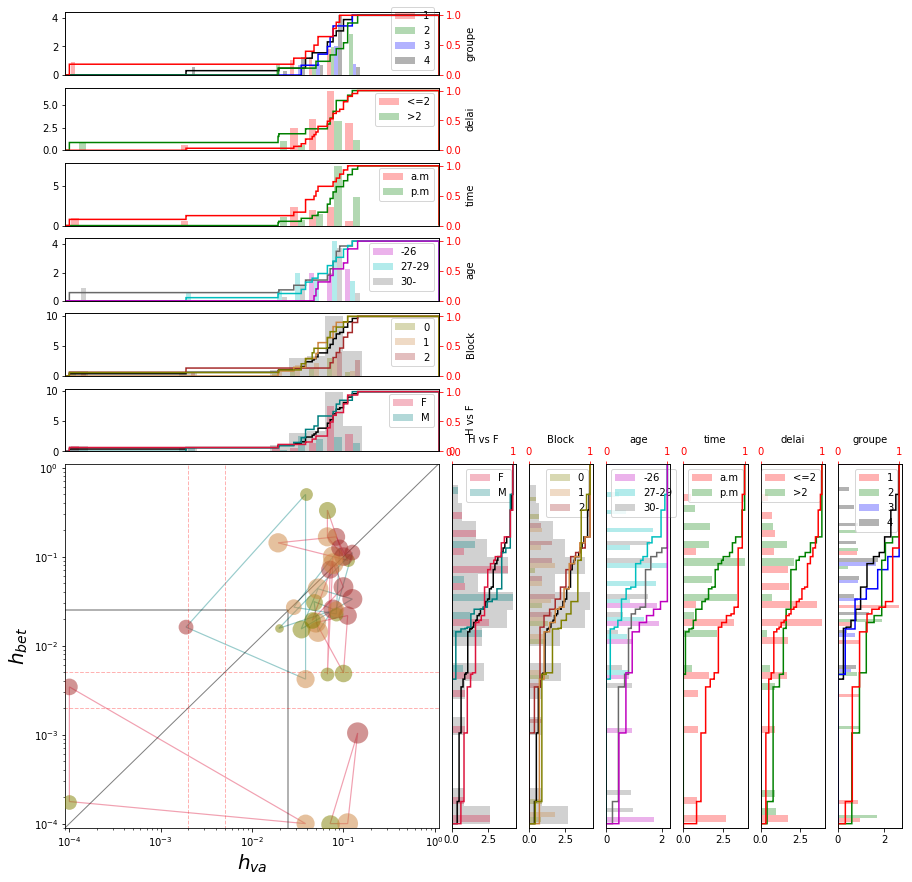



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.1756		0.3430		0.2886
BLOCK 0 vs 1 :		0.4654		0.9078		0.9985
BLOCK 0 vs 2 :		0.0230		0.0429		0.0995
BLOCK 1 vs 2 :		0.0200		0.0373		0.0995
AGE -26 vs 27-29 :	0.0846		0.1600		0.2653
AGE -26 vs 30- :	0.0826		0.1545		0.2681
AGE 27-29 vs 30- :	0.3388		0.6598		0.9059
TIME a.m vs p.m :	0.0206		0.0397		0.0582
DELAI <=2 vs >2 :	0.1956		0.3821		0.4852
GROUPE 1 vs 2 :		0.0150		0.0268		0.1259
GROUPE 1 vs 3 :		0.1576		0.2875		0.5628
GROUPE 1 vs 4 :		0.1680		0.3183		0.8506
GROUPE 2 vs 3 :		0.1718		0.3143		0.2735
GROUPE 2 vs 4 :		0.0583		0.1085		0.4272
GROUPE 3 vs 2 :		0.1718		0.3143		0.2735
GROUPE 3 vs 4 :		0.4071		0.7778		0.9607

Significatif : ['B 0-2', 'B 1-2', 'a.m-p.m', 'G 1-2']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	

In [13]:
fig, SIGNIFICATIF['R']['sans scalling']['sans pourcentage'] = plot_fig(recording, pourcentage=None)

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

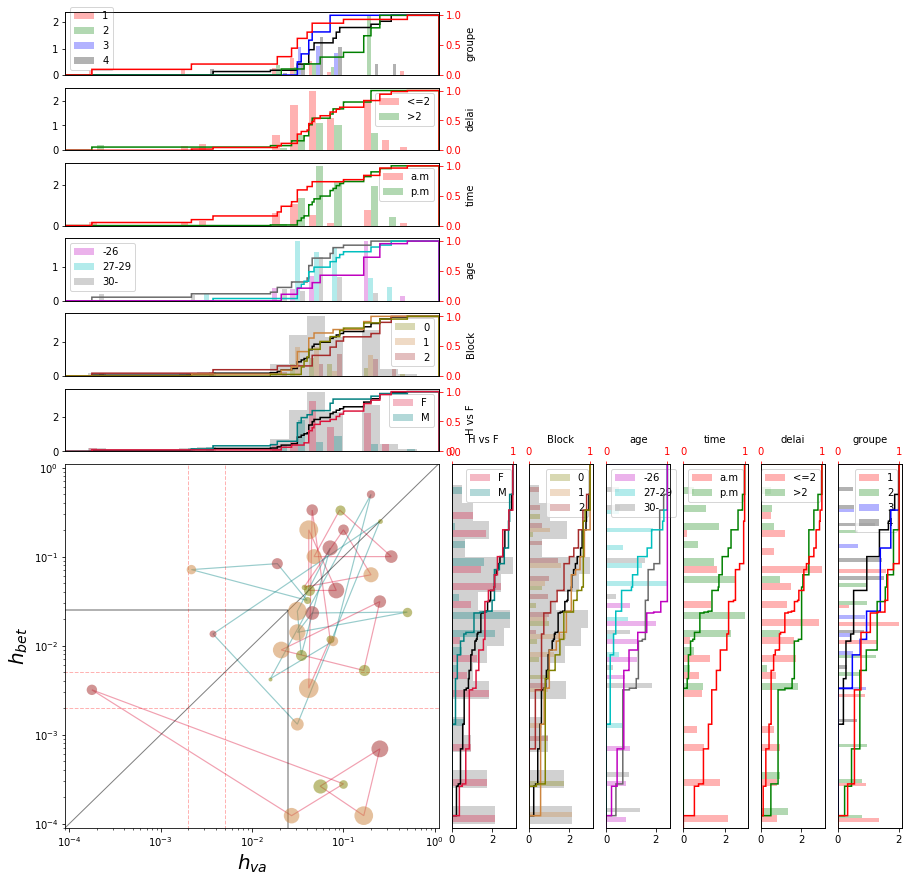



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.0524		0.1014		0.0800
BLOCK 0 vs 1 :		0.0663		0.1253		0.2558
BLOCK 0 vs 2 :		0.4425		0.8623		0.9985
BLOCK 1 vs 2 :		0.1016		0.1932		0.2558
AGE -26 vs 27-29 :	0.1695		0.3241		0.3936
AGE -26 vs 30- :	0.0232		0.0426		0.1590
AGE 27-29 vs 30- :	0.0936		0.1791		0.3142
TIME a.m vs p.m :	0.0635		0.1231		0.0499
DELAI <=2 vs >2 :	0.4136		0.8141		0.8669
GROUPE 1 vs 2 :		0.0286		0.0517		0.1259
GROUPE 1 vs 3 :		0.1576		0.2875		0.4084
GROUPE 1 vs 4 :		0.1003		0.1883		0.2681
GROUPE 2 vs 3 :		0.0433		0.0763		0.0611
GROUPE 2 vs 4 :		0.1593		0.3017		0.2681
GROUPE 3 vs 2 :		0.0433		0.0763		0.0611
GROUPE 3 vs 4 :		0.1989		0.3721		0.2538

Significatif : ['A -26 - 30-', 'a.m-p.m', 'G 1-2', 'G 2-3', 'G 3-2']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
	

In [14]:
fig, SIGNIFICATIF['MI']['sans scalling']['sans pourcentage'] = plot_fig(recording_mi, pourcentage=None)

## pourcentage 99%

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

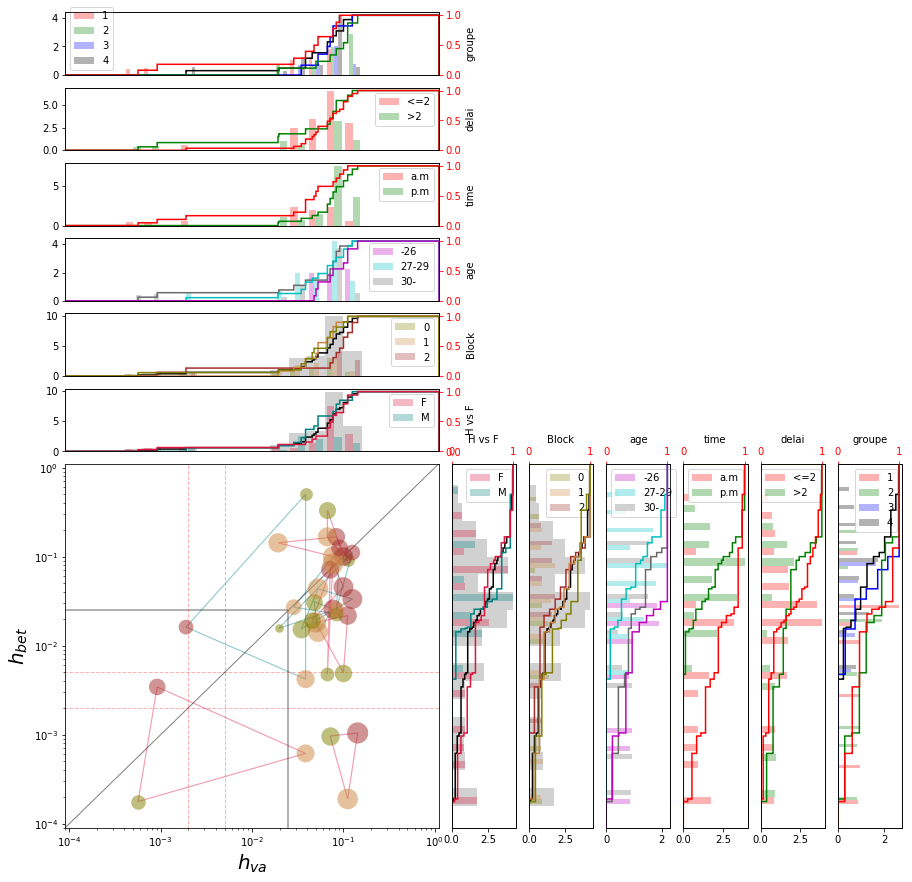



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.1756		0.3430		0.2886
BLOCK 0 vs 1 :		0.4654		0.9078		0.9985
BLOCK 0 vs 2 :		0.0214		0.0400		0.0995
BLOCK 1 vs 2 :		0.0200		0.0373		0.0995
AGE -26 vs 27-29 :	0.0846		0.1600		0.2653
AGE -26 vs 30- :	0.0826		0.1547		0.2681
AGE 27-29 vs 30- :	0.3388		0.6598		0.9059
TIME a.m vs p.m :	0.0206		0.0397		0.0582
DELAI <=2 vs >2 :	0.1957		0.3821		0.4852
GROUPE 1 vs 2 :		0.0150		0.0269		0.1259
GROUPE 1 vs 3 :		0.1578		0.2880		0.5628
GROUPE 1 vs 4 :		0.1680		0.3185		0.8506
GROUPE 2 vs 3 :		0.1718		0.3143		0.2735
GROUPE 2 vs 4 :		0.0583		0.1085		0.4272
GROUPE 3 vs 2 :		0.1718		0.3143		0.2735
GROUPE 3 vs 4 :		0.4071		0.7778		0.9607

Significatif : ['B 0-2', 'B 1-2', 'a.m-p.m', 'G 1-2']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	

In [15]:
fig, SIGNIFICATIF['R']['sans scalling']['pourcentage 99%'] = plot_fig(recording)

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

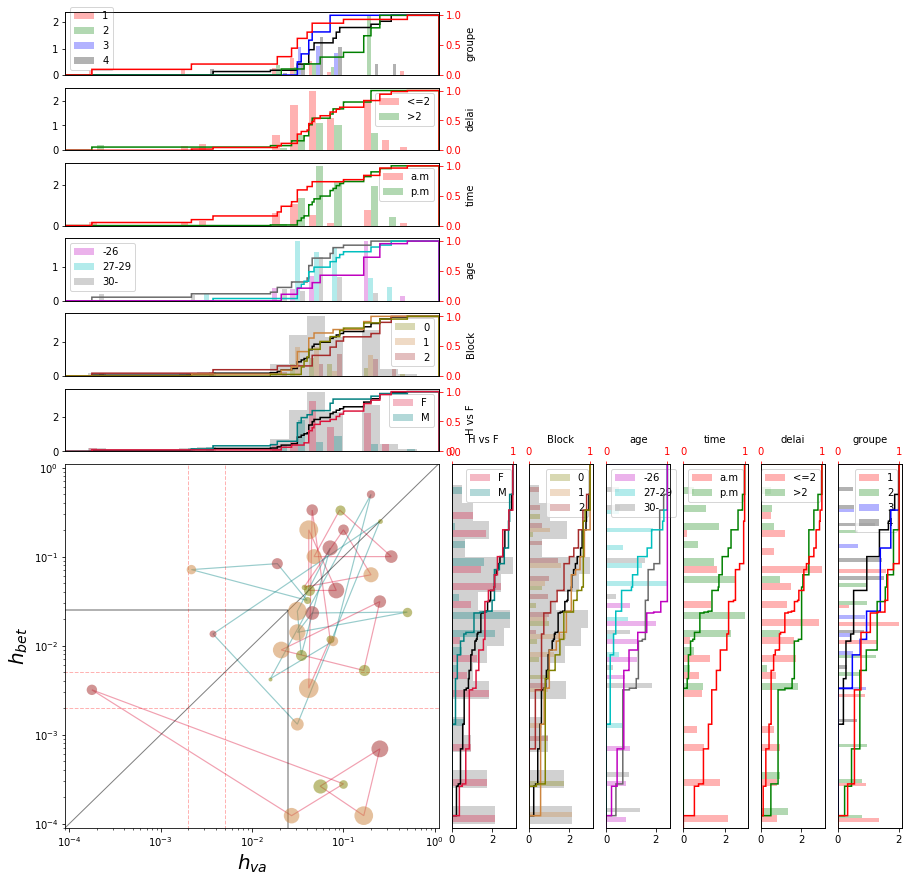



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.0524		0.1014		0.0800
BLOCK 0 vs 1 :		0.0663		0.1253		0.2558
BLOCK 0 vs 2 :		0.4425		0.8623		0.9985
BLOCK 1 vs 2 :		0.1016		0.1932		0.2558
AGE -26 vs 27-29 :	0.1695		0.3241		0.3936
AGE -26 vs 30- :	0.0232		0.0426		0.1590
AGE 27-29 vs 30- :	0.0936		0.1791		0.3142
TIME a.m vs p.m :	0.0635		0.1231		0.0499
DELAI <=2 vs >2 :	0.4136		0.8141		0.8669
GROUPE 1 vs 2 :		0.0286		0.0517		0.1259
GROUPE 1 vs 3 :		0.1576		0.2875		0.4084
GROUPE 1 vs 4 :		0.1003		0.1883		0.2681
GROUPE 2 vs 3 :		0.0433		0.0763		0.0611
GROUPE 2 vs 4 :		0.1593		0.3017		0.2681
GROUPE 3 vs 2 :		0.0433		0.0763		0.0611
GROUPE 3 vs 4 :		0.1989		0.3721		0.2538

Significatif : ['A -26 - 30-', 'a.m-p.m', 'G 1-2', 'G 2-3', 'G 3-2']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
	

In [16]:
fig, SIGNIFICATIF['MI']['sans scalling']['pourcentage 99%'] = plot_fig(recording_mi)

---------------------------------

## Scalling sujet

In [17]:
SIGNIFICATIF['R']['scalling sujet'] = {}
SIGNIFICATIF['MI']['scalling sujet'] = {}

In [18]:
file = os.path.join('../parametre/list_h', 'list_h_block_Scalling_sujet.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
file = os.path.join('../parametre/list_h', 'list_h_MI_block_Scalling_sujet.pkl')
with open(file, 'rb') as fichier:
    recording_mi = pickle.load(fichier, encoding='latin1')

## sans pourcentage

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

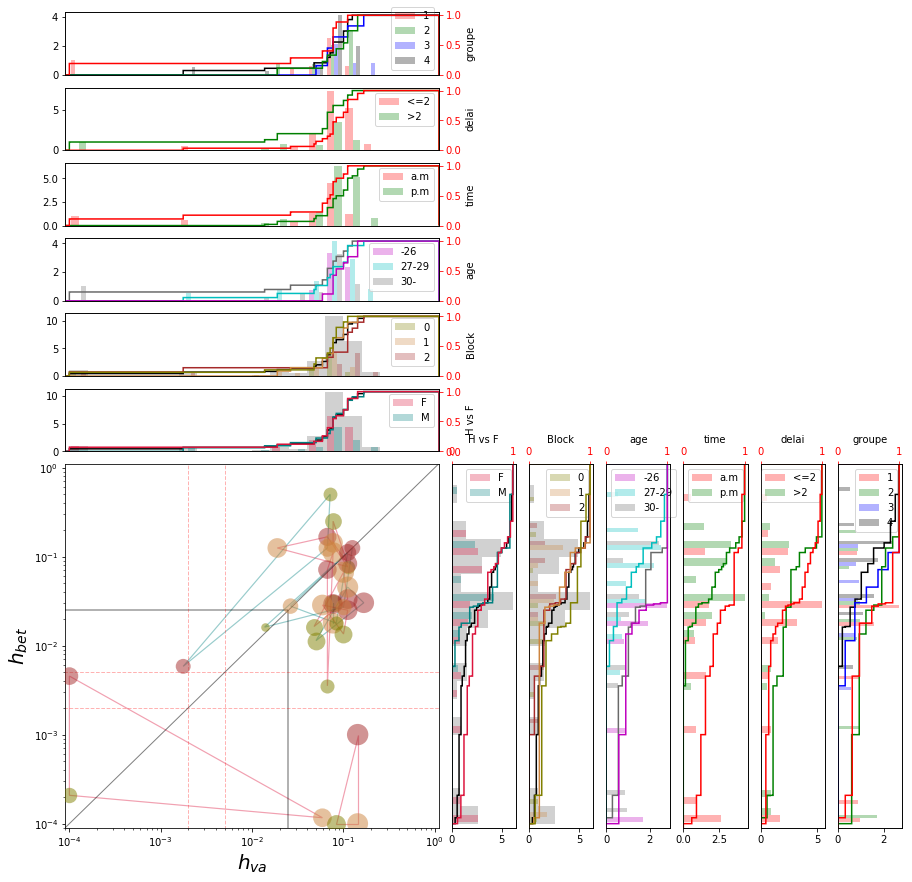



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.4807		0.9485		0.9999
BLOCK 0 vs 1 :		0.2905		0.5613		0.9985
BLOCK 0 vs 2 :		0.0583		0.1100		0.0995
BLOCK 1 vs 2 :		0.1282		0.2444		0.2558
AGE -26 vs 27-29 :	0.1327		0.2528		0.3936
AGE -26 vs 30- :	0.0370		0.0684		0.1590
AGE 27-29 vs 30- :	0.1632		0.3145		0.9059
TIME a.m vs p.m :	0.0341		0.0659		0.4374
DELAI <=2 vs >2 :	0.0283		0.0544		0.1135
GROUPE 1 vs 2 :		0.0457		0.0832		0.3517
GROUPE 1 vs 3 :		0.2191		0.4039		0.7794
GROUPE 1 vs 4 :		0.1666		0.3156		0.6383
GROUPE 2 vs 3 :		0.3832		0.7215		0.7794
GROUPE 2 vs 4 :		0.1764		0.3347		0.8506
GROUPE 3 vs 2 :		0.3832		0.7215		0.7794
GROUPE 3 vs 4 :		0.4438		0.8504		0.9607

Significatif : ['A -26 - 30-', 'a.m-p.m', 'D <=2 - >2', 'G 1-2']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			--

In [19]:
fig, SIGNIFICATIF['R']['scalling sujet']['sans pourcentage'] = plot_fig(recording, pourcentage=None)

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

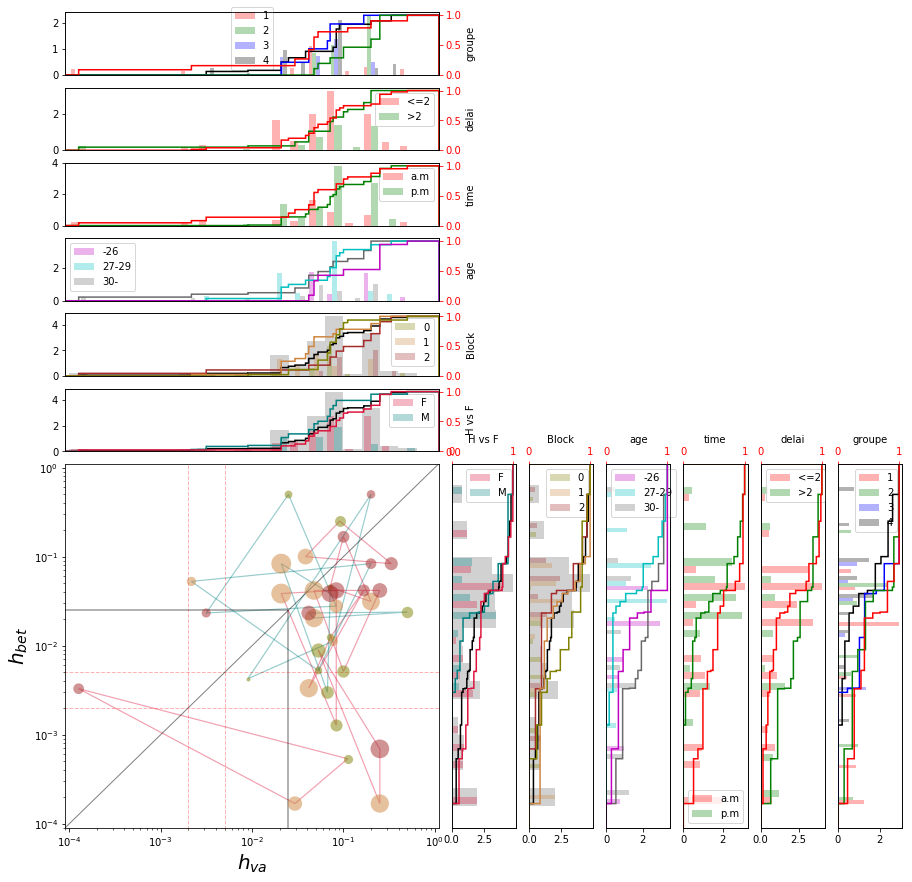



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.0697		0.1352		0.3201
BLOCK 0 vs 1 :		0.0919		0.1744		0.0995
BLOCK 0 vs 2 :		0.1423		0.2717		0.2558
BLOCK 1 vs 2 :		0.0557		0.1051		0.2558
AGE -26 vs 27-29 :	0.0993		0.1884		0.3242
AGE -26 vs 30- :	0.0628		0.1170		0.2057
AGE 27-29 vs 30- :	0.3753		0.7322		0.9059
TIME a.m vs p.m :	0.1482		0.2890		0.2886
DELAI <=2 vs >2 :	0.4799		0.9464		0.8669
GROUPE 1 vs 2 :		0.0505		0.0920		0.3517
GROUPE 1 vs 3 :		0.3616		0.6794		0.7794
GROUPE 1 vs 4 :		0.4434		0.8588		0.8506
GROUPE 2 vs 3 :		0.0425		0.0747		0.2735
GROUPE 2 vs 4 :		0.0435		0.0807		0.1138
GROUPE 3 vs 2 :		0.0425		0.0747		0.2735
GROUPE 3 vs 4 :		0.3890		0.7423		0.4680

Significatif : ['G 2-3', 'G 2-4', 'G 3-2']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--

In [20]:
fig, SIGNIFICATIF['MI']['scalling sujet']['sans pourcentage'] = plot_fig(recording_mi, pourcentage=None)

## pourcentage 99%

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

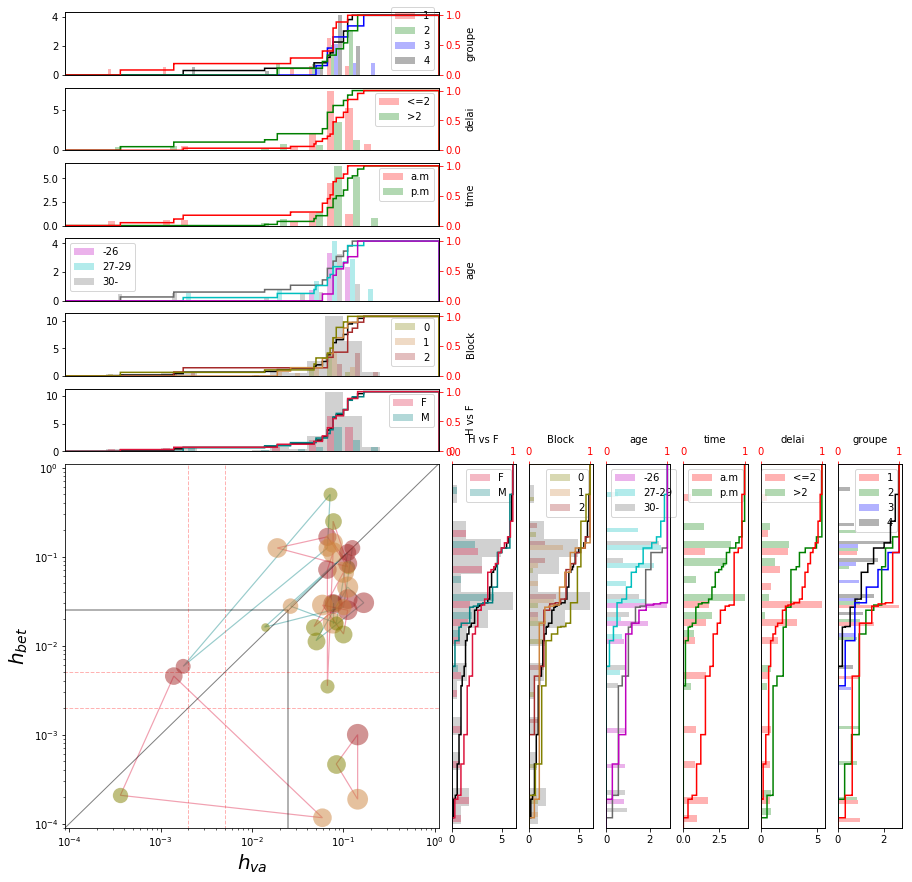



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.4807		0.9485		0.9999
BLOCK 0 vs 1 :		0.2905		0.5613		0.9985
BLOCK 0 vs 2 :		0.0550		0.1038		0.0995
BLOCK 1 vs 2 :		0.1282		0.2444		0.2558
AGE -26 vs 27-29 :	0.1327		0.2528		0.3936
AGE -26 vs 30- :	0.0371		0.0685		0.1590
AGE 27-29 vs 30- :	0.1633		0.3146		0.9059
TIME a.m vs p.m :	0.0341		0.0659		0.4374
DELAI <=2 vs >2 :	0.0283		0.0544		0.1135
GROUPE 1 vs 2 :		0.0458		0.0833		0.3517
GROUPE 1 vs 3 :		0.2194		0.4043		0.7794
GROUPE 1 vs 4 :		0.1667		0.3158		0.6383
GROUPE 2 vs 3 :		0.3832		0.7215		0.7794
GROUPE 2 vs 4 :		0.1764		0.3347		0.8506
GROUPE 3 vs 2 :		0.3832		0.7215		0.7794
GROUPE 3 vs 4 :		0.4438		0.8504		0.9607

Significatif : ['A -26 - 30-', 'a.m-p.m', 'D <=2 - >2', 'G 1-2']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			--

In [21]:
fig, SIGNIFICATIF['R']['scalling sujet']['pourcentage 99%']  = plot_fig(recording)

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

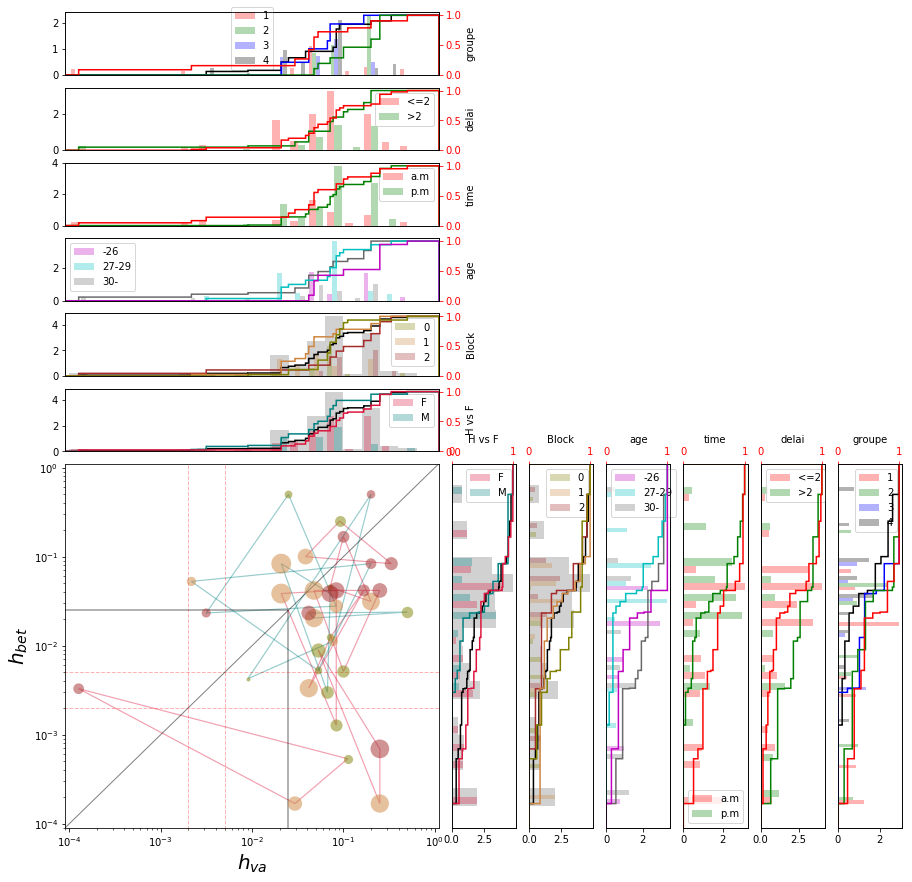



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.0697		0.1352		0.3201
BLOCK 0 vs 1 :		0.0919		0.1744		0.0995
BLOCK 0 vs 2 :		0.1423		0.2717		0.2558
BLOCK 1 vs 2 :		0.0557		0.1051		0.2558
AGE -26 vs 27-29 :	0.0993		0.1884		0.3242
AGE -26 vs 30- :	0.0628		0.1170		0.2057
AGE 27-29 vs 30- :	0.3753		0.7322		0.9059
TIME a.m vs p.m :	0.1482		0.2890		0.2886
DELAI <=2 vs >2 :	0.4799		0.9464		0.8669
GROUPE 1 vs 2 :		0.0505		0.0920		0.3517
GROUPE 1 vs 3 :		0.3616		0.6794		0.7794
GROUPE 1 vs 4 :		0.4434		0.8588		0.8506
GROUPE 2 vs 3 :		0.0425		0.0747		0.2735
GROUPE 2 vs 4 :		0.0435		0.0807		0.1138
GROUPE 3 vs 2 :		0.0425		0.0747		0.2735
GROUPE 3 vs 4 :		0.3890		0.7423		0.4680

Significatif : ['G 2-3', 'G 2-4', 'G 3-2']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--

In [22]:
fig, SIGNIFICATIF['MI']['scalling sujet']['pourcentage 99%']  = plot_fig(recording_mi)

---------------------------------

## Scalling full

In [23]:
SIGNIFICATIF['R']['scalling full'] = {}
SIGNIFICATIF['MI']['scalling full'] = {}

In [24]:
file = os.path.join('../parametre/list_h', 'list_h_block_Scalling_full.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
file = os.path.join('../parametre/list_h', 'list_h_MI_block_Scalling_full.pkl')
with open(file, 'rb') as fichier:
    recording_mi = pickle.load(fichier, encoding='latin1')

## sans pourcentage

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

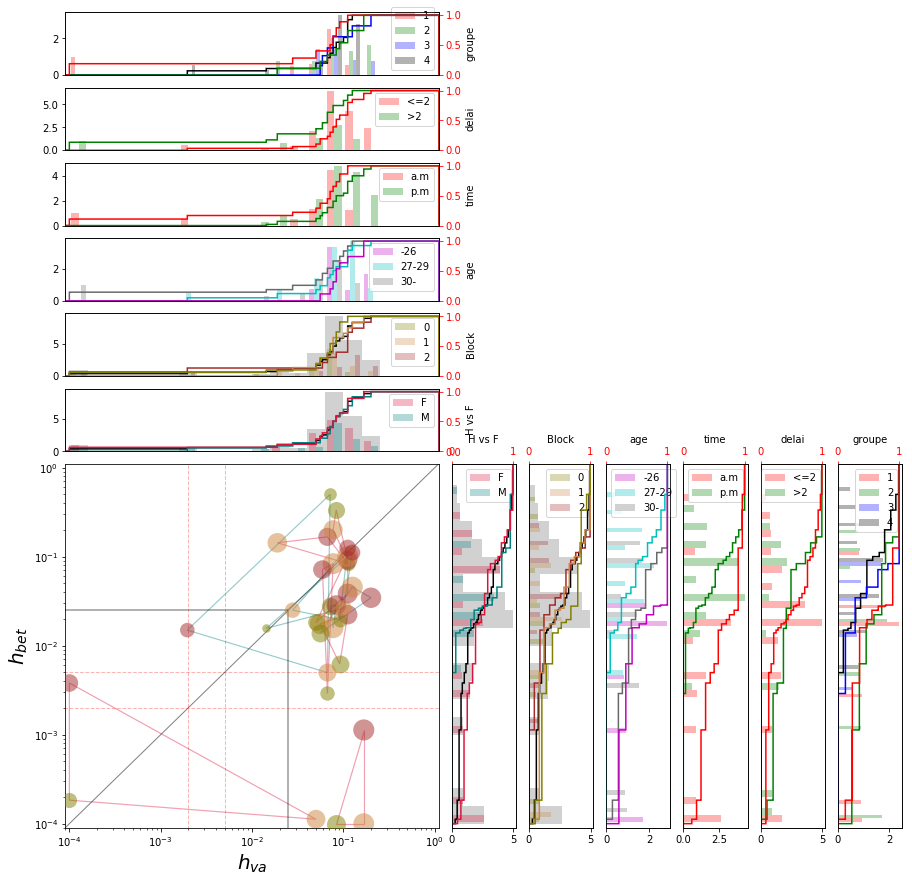



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.4297		0.8468		0.9996
BLOCK 0 vs 1 :		0.2912		0.5628		0.8690
BLOCK 0 vs 2 :		0.0551		0.1038		0.0995
BLOCK 1 vs 2 :		0.1764		0.3379		0.5361
AGE -26 vs 27-29 :	0.1921		0.3681		0.6408
AGE -26 vs 30- :	0.0437		0.0811		0.1590
AGE 27-29 vs 30- :	0.1103		0.2114		0.7863
TIME a.m vs p.m :	0.0248		0.0477		0.2036
DELAI <=2 vs >2 :	0.0200		0.0384		0.1135
GROUPE 1 vs 2 :		0.0552		0.1009		0.7301
GROUPE 1 vs 3 :		0.1725		0.3156		0.4084
GROUPE 1 vs 4 :		0.1266		0.2387		0.6383
GROUPE 2 vs 3 :		0.4296		0.8130		0.7794
GROUPE 2 vs 4 :		0.2261		0.4309		0.9318
GROUPE 3 vs 2 :		0.4296		0.8130		0.7794
GROUPE 3 vs 4 :		0.4254		0.8142		0.9607

Significatif : ['A -26 - 30-', 'a.m-p.m', 'D <=2 - >2']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			-----------

In [25]:
fig, SIGNIFICATIF['R']['scalling full']['sans pourcentage'] = plot_fig(recording, pourcentage=None)

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

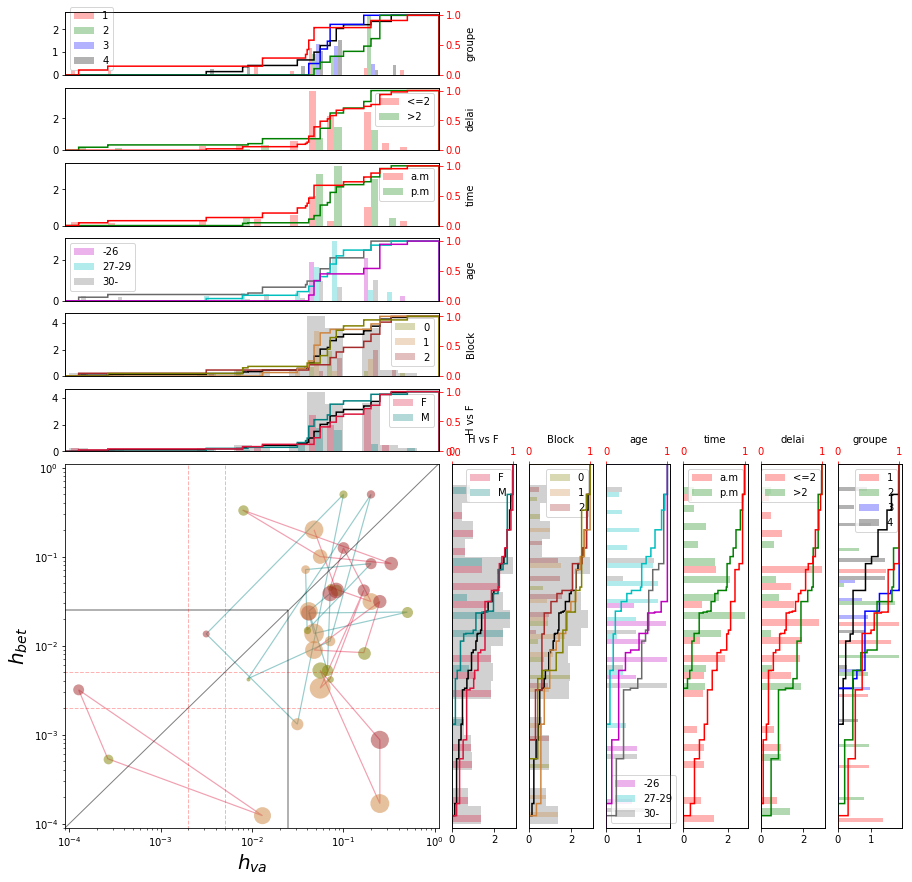



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.1634		0.3189		0.4374
BLOCK 0 vs 1 :		0.3113		0.6024		0.5361
BLOCK 0 vs 2 :		0.0917		0.1740		0.5361
BLOCK 1 vs 2 :		0.0624		0.1178		0.0995
AGE -26 vs 27-29 :	0.1159		0.2203		0.2139
AGE -26 vs 30- :	0.0250		0.0460		0.1138
AGE 27-29 vs 30- :	0.1893		0.3654		0.4958
TIME a.m vs p.m :	0.0457		0.0884		0.0257
DELAI <=2 vs >2 :	0.2838		0.5563		0.6838
GROUPE 1 vs 2 :		0.0134		0.0239		0.0336
GROUPE 1 vs 3 :		0.0624		0.1110		0.0947
GROUPE 1 vs 4 :		0.2067		0.3933		0.4272
GROUPE 2 vs 3 :		0.0542		0.0959		0.2735
GROUPE 2 vs 4 :		0.0373		0.0690		0.2681
GROUPE 3 vs 2 :		0.0542		0.0959		0.2735
GROUPE 3 vs 4 :		0.4255		0.8143		0.7596

Significatif : ['A -26 - 30-', 'a.m-p.m', 'G 1-2', 'G 2-4']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			-------

In [26]:
fig, SIGNIFICATIF['MI']['scalling full']['sans pourcentage'] = plot_fig(recording_mi, pourcentage=None)

## pourcentage 99%

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

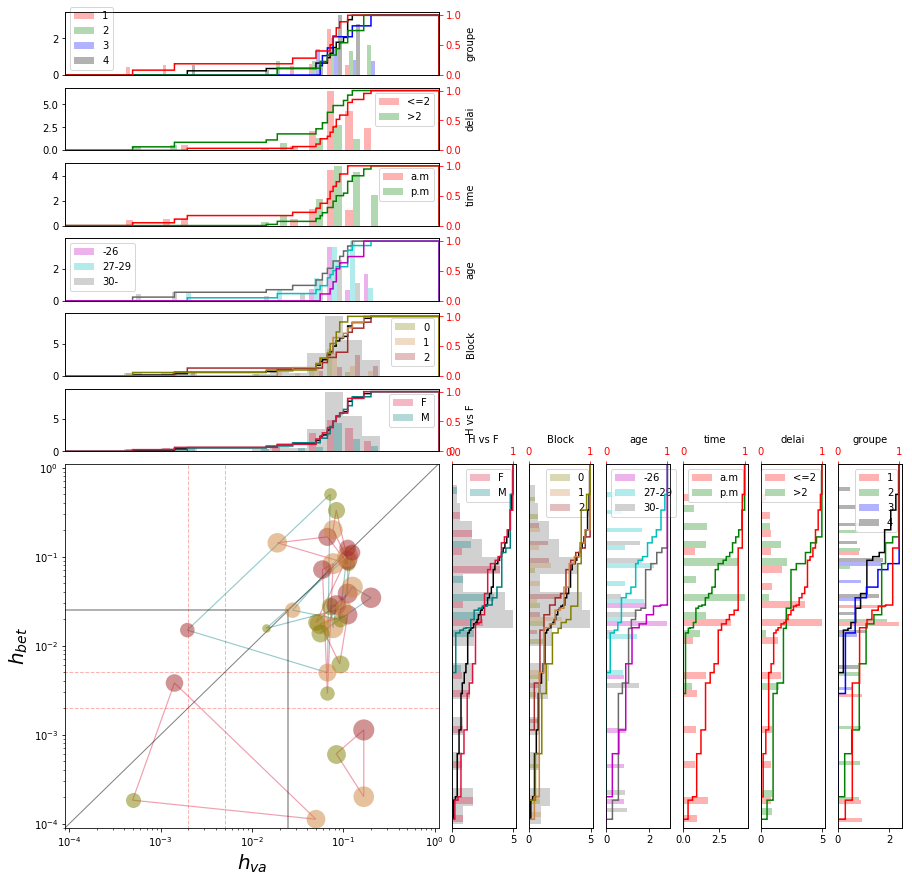



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.4297		0.8468		0.9996
BLOCK 0 vs 1 :		0.2912		0.5628		0.8690
BLOCK 0 vs 2 :		0.0520		0.0979		0.0995
BLOCK 1 vs 2 :		0.1764		0.3379		0.5361
AGE -26 vs 27-29 :	0.1921		0.3681		0.6408
AGE -26 vs 30- :	0.0438		0.0812		0.1590
AGE 27-29 vs 30- :	0.1103		0.2115		0.7863
TIME a.m vs p.m :	0.0248		0.0477		0.2036
DELAI <=2 vs >2 :	0.0200		0.0384		0.1135
GROUPE 1 vs 2 :		0.0553		0.1011		0.7301
GROUPE 1 vs 3 :		0.1727		0.3160		0.4084
GROUPE 1 vs 4 :		0.1267		0.2388		0.6383
GROUPE 2 vs 3 :		0.4296		0.8130		0.7794
GROUPE 2 vs 4 :		0.2261		0.4309		0.9318
GROUPE 3 vs 2 :		0.4296		0.8130		0.7794
GROUPE 3 vs 4 :		0.4254		0.8142		0.9607

Significatif : ['A -26 - 30-', 'a.m-p.m', 'D <=2 - >2']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			-----------

In [27]:
fig, SIGNIFICATIF['R']['scalling full']['pourcentage 99%']   = plot_fig(recording)

s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 

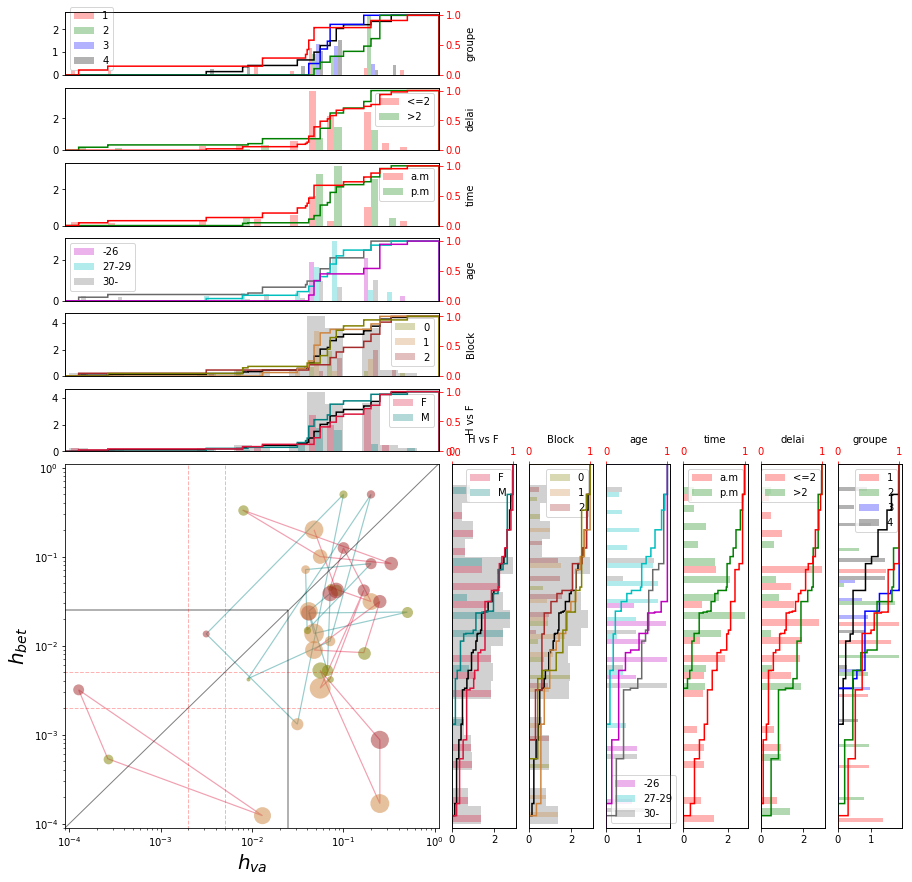



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.1634		0.3189		0.4374
BLOCK 0 vs 1 :		0.3113		0.6024		0.5361
BLOCK 0 vs 2 :		0.0917		0.1740		0.5361
BLOCK 1 vs 2 :		0.0624		0.1178		0.0995
AGE -26 vs 27-29 :	0.1159		0.2203		0.2139
AGE -26 vs 30- :	0.0250		0.0460		0.1138
AGE 27-29 vs 30- :	0.1893		0.3654		0.4958
TIME a.m vs p.m :	0.0457		0.0884		0.0257
DELAI <=2 vs >2 :	0.2838		0.5563		0.6838
GROUPE 1 vs 2 :		0.0134		0.0239		0.0336
GROUPE 1 vs 3 :		0.0624		0.1110		0.0947
GROUPE 1 vs 4 :		0.2067		0.3933		0.4272
GROUPE 2 vs 3 :		0.0542		0.0959		0.2735
GROUPE 2 vs 4 :		0.0373		0.0690		0.2681
GROUPE 3 vs 2 :		0.0542		0.0959		0.2735
GROUPE 3 vs 4 :		0.4255		0.8143		0.7596

Significatif : ['A -26 - 30-', 'a.m-p.m', 'G 1-2', 'G 2-4']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			-------

In [28]:
fig, SIGNIFICATIF['MI']['scalling full']['pourcentage 99%']   = plot_fig(recording_mi)

---------------------------------

In [29]:
print('SIGNIFICATIF')

print('(pourcentage 99% ne change pas la signicativité)')

for h in ['h_va', 'h_bet'] :
    print('\n\n', h, '\n', '-'*75, sep='')
    
    for r_ in ['R', 'MI'] :
        print('\n', r_, sep='')
        for s in ['sans scalling', 'scalling sujet', 'scalling full'] :
            print('\n', s, '\t:', sep='')
            for c in ['SANS COUPE', 'Coupe à h=0.002', 'Coupe à h=0.005'] :
                print('\t', c, '\t: ', SIGNIFICATIF[r_][s]['sans pourcentage'][h][c], sep='')
                
                #print('\t', c, '\t:', sep='')
                #for p in ['sans pourcentage', 'pourcentage 99%'] :
                #    print('\t\t', p, ' : ', SIGNIFICATIF[r_][s][p][h][c], sep='')

SIGNIFICATIF
(pourcentage 99% ne change pas la signicativité)


h_va
---------------------------------------------------------------------------

R

sans scalling	:
	SANS COUPE	: ['B 0-2', 'B 1-2', 'a.m-p.m', 'G 1-2']
	Coupe à h=0.002	: ['B 0-2', 'B 1-2', 'G 1-2']
	Coupe à h=0.005	: ['B 0-2', 'B 1-2', 'G 1-2']

scalling sujet	:
	SANS COUPE	: ['A -26 - 30-', 'a.m-p.m', 'D <=2 - >2', 'G 1-2']
	Coupe à h=0.002	: ['B 0-2', 'B 1-2']
	Coupe à h=0.005	: ['B 0-2', 'B 1-2']

scalling full	:
	SANS COUPE	: ['A -26 - 30-', 'a.m-p.m', 'D <=2 - >2']
	Coupe à h=0.002	: ['B 0-2', 'B 1-2', 'D <=2 - >2']
	Coupe à h=0.005	: ['B 0-2', 'B 1-2', 'D <=2 - >2']

MI

sans scalling	:
	SANS COUPE	: ['A -26 - 30-', 'a.m-p.m', 'G 1-2', 'G 2-3', 'G 3-2']
	Coupe à h=0.002	: ['H-F', 'B 1-2', 'A -26 - 30-', 'G 2-3', 'G 3-2']
	Coupe à h=0.005	: ['B 1-2', 'G 2-3', 'G 3-2']

scalling sujet	:
	SANS COUPE	: ['G 2-3', 'G 2-4', 'G 3-2']
	Coupe à h=0.002	: ['H-F', 'B 1-2', 'G 2-3', 'G 2-4', 'G 3-2']
	Coupe à h=0.005	: ['B 0-2